# Исследование данных магазина и разработка ML-решений для предсказания вероятности покупки 

**Описание**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время. 

**Данные:**

В исследовании используются данные интернет-магазина из 3 файлов: 
*  apparel-purchases - история покупок
*  apparel-messages - история рекламных рассылок
*  apparel-target_binary - совершит ли клиент покупку в течение следующих 90 дней
  
**Цели исследования:**

* Предсказать вероятность покупки в течение 90 дней

**Задачи исследования:**

* Изучить и проанализировать данные интернет-магазина
* Разработать полезные признаки
* Создать модель для классификации пользователей (использовать все возможные модели бинарной классификации)
* Улучшить модель и максимизировать метрику roc_auc
* Выполнить тестирование

**Результат:**

Репозиторий на GitHub: c тетрадью jupyter notebook и описанием, подготовкой признаков, обучением модели и
тестированием, с описанием проекта и инструкцией по использованию.

**Стэк**

* python
* pandas
* sklearn



##  Исследование файлов с данными и изучение общей информации

### Импорт основных библиотек:

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

import phik
import os
import warnings
import time

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve

In [3]:
warnings.filterwarnings('ignore')

### Глобальные переменные и функции, использующиеся в проекте

In [4]:
# мои универсальные функции: этот блок содержит все часто используемые функции (можно свернуть)

# 0. функция для записи файлов с попыткой загрузки с локального сервера, и с файл-сервера 
def write_read_csv(local, remote): 
    try:
        if os.path.exists(local):
            return pd.read_csv(local)
        elif os.path.exists(remote):
            return pd.read_csv(remote)
    except FileNotFoundError:
        print('Файл не найден')


# 1. функция для вывода общей информации
def show_info(dt):
    dt.info(show_counts=True)
    display(dt.head())

# 2. функция для вывода соотношения пропусков
def isna_table(dt):
    return pd.DataFrame(round(dt.isna().sum())).style.background_gradient('coolwarm')


# 3. функция для вывода статистик для каждого параметра
def stats_describe(name, df, columns):
    stats = df[columns].describe().T
    stats = stats.style.set_caption(f"<b>{name}</b>") 
    return stats


# 4. функция для построения графиков распределения по показателям
def plot_enhanced(df, cols, labels_dict, plot_type='auto', figsize=(24, 20)):
    n_cols = min(3, len(cols))  # не более 3 колонок
    n_rows = (len(cols) + n_cols - 1) // n_cols
    # автоподбор размера для одиночного графика
    if len(cols) == 1:
        figsize = (figsize[0], 5)  # фиксированная высота для одного графика
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()  # для единообразия обработки
    for i, col in enumerate(cols):
        ax = axes[i]
        # автовыбор типа графика
        if plot_type == 'auto':
            current_plot_type = 'count' if df[col].nunique() <= 15 else 'hist'
        else:
            current_plot_type = plot_type
        # построение графиков
        if current_plot_type == 'count':
            sns.countplot(x=col, data=df, ax=ax, color='#DDA00D', alpha=0.85)
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)
        else:
            sns.histplot(df[col], ax=ax, color='#DDA00D', alpha=0.85, kde=True, bins=15)
        # установка подписей
        title, xlabel, ylabel = labels_dict.get(col, ['', '', ''])
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(labelsize=9)  
     # скрываем неиспользуемые оси
    for i in range(len(cols), len(axes)):
        axes[i].set_visible(False)
    # единый заголовок для всей фигуры
    fig.suptitle('Анализ распределения показателей', 
                 fontsize=16, 
                 fontweight='bold',
                 y=0.98 if len(cols) > 1 else 0.95)  # разное положение для 1 и >1 графиков   
    plt.tight_layout()
    plt.subplots_adjust(top=0.9 if len(cols) > 1 else 0.85)  # рег-ка верхнего отступа
    plt.show()


# 5. функция столбчатые диаграммы для категориальных признаков
def bar_plot(df, cols, translation_dict):
    for col_name in cols:
        # получаем данные для построения
        value_counts = df[col_name].value_counts()
        
        # ДОБАВЛЯЕМ: если категорий больше 10, берем только топ-10
        if len(value_counts) > 10:
            value_counts = value_counts.head(10)
        # русское название для отображения
        display_name = translation_dict.get(col_name, col_name)
        
        # создаем график
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
        # добавляем значения на столбцы
        for i, v in enumerate(value_counts.values):
            ax.text(i, v + 0.01 * max(value_counts.values), str(v), 
                    ha='center', va='bottom', fontweight='bold')
        # внешний вид
        plt.title(f'Распределение показателя "{display_name}"', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(display_name, fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.xticks(rotation=45, ha='right') 
        plt.show()


# 6. функция для построения матницы корреляции
def plot_phik_matrices (dt, interval_cols, name):
    corr_matrix = dt.phik_matrix(interval_cols=interval_cols)
    # визуализация матрицы корреляций
    plt.figure(figsize=(28, 25))
    sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, 
            vmax=1,
            annot_kws={"size": 17},
            linewidths=0.5)
    plt.title(name, fontsize=25, pad=20, fontweight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=15)
    plt.yticks(rotation=0, fontsize=15)
    plt.show()


# 7. функция для рассчета VIF для признаков в датасете 
def vif_corr (df, cols):
    vif_data = pd.DataFrame()
    vif_data["feature"] = cols
    vif_data["VIF"] = [
        variance_inflation_factor(df[cols].values, i) 
        for i in range(len(cols))]
    return vif_data.sort_values("VIF", ascending=False)


# 8. функция display_scatterplot для визуализации диаграмм рассеяния 
def display_scatterplot(data, x_col, y_col, ax, hue=None, alpha=1.0, title='', xlabel='', ylabel=''):
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue, alpha=alpha, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

In [5]:
# зададим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
CONST = 10

### Запись данных из csv-файлов и сохранение в датафреймы.

In [6]:
# запишем данные из csv-файлов в датафреймы (с local и remote серверов)
dt_messages = write_read_csv(
    'datasets/apparel-messages.csv', 
    'https://drive.google.com/file/d/18VXr3S3FXi2RovLPaGQV_cRqndkH-WlZ/view?usp=drive_link')
dt_purchases = write_read_csv(
    'datasets/apparel-purchases.csv', 
    'https://drive.google.com/file/d/1UhYjOwEiwZbfQux4Lak3BC6riA8WYCpy/view?usp=drive_link')
dt_target = write_read_csv(
    'datasets/apparel-target_binary.csv', 
    'https://drive.google.com/file/d/1v6hMdAVjRCNrJjceKTlIM1-SrX1WMDcl/view?usp=drive_link')

###  Вывод общей информации

In [7]:
show_info(dt_messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [8]:
show_info(dt_purchases)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [9]:
show_info(dt_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


По общей информации и первым строкам видно, что датафреймы `dt_messages`, `dt_purchases`, `dt_target` содержат данные с характеристиками историй покупок клиентов, историй рекламных рассылок и целевой признак - совершит ли клиент покупку в течение следующих 90 дней.

Данные в таблицах соответствуют описанию. Предвариетельно пропуски в данных не обнаружены. Стиль названия всех колонок соответствует snake case. Предеварительно есть вопросы к типам данным в колонках c  датами, к данным столбца `category_ids`, работа над которыми предстоит на этапе предобработки данных. 

**Вывод по исследованию файлов и изучению общей информации**

* Данные из трёх csv-файлов: `apparel-purchases, apparel-messages и apparel-target_binary` были загружены в датафреймы `dt_messages`, `dt_purchases`, `dt_target`
* Было изучено название полей датафреймов и замечено отсутствие пропусков во всех датафреймах.

##  Предобработка данных

### Оптимизация типов данных

Столбцы с датами  в датафрейме с покупками `dt_purchases`: `date`,  в датафрейме с сообщениями `dt_messages`: `created_at` приведем  к типу datetime.

In [10]:
dt_purchases['date'] = pd.to_datetime(dt_purchases['date'])
dt_messages['date'] = pd.to_datetime(dt_messages['date'])
dt_messages['created_at'] = pd.to_datetime(dt_messages['created_at'])

**Вывод**: Признаки `date` и `created_at` преведены к типу datetime.

### Обработка пропущенных значений и дубликатов в датафреймах.

Перед обработкой пропущенных значений и дубликатов создадим копию датафрейма и зафиксируем их размер до преобразования:

In [11]:
temp_dt_messages = dt_messages.copy() 
print(f'Длина датасета dt_messages: {len(temp_dt_messages)}')

Длина датасета dt_messages: 12739798


In [12]:
temp_dt_purchases = dt_purchases.copy() 
print(f'Длина датасета dt_purchases: {len(temp_dt_purchases)}')

Длина датасета dt_purchases: 202208


In [13]:
temp_dt_target = dt_target.copy() 
print(f'Длина датасета dt_target: {len(temp_dt_target)}')

Длина датасета dt_target: 49849


Ранее мы уже проверили датасеты на отсутсвие пропусков. Теперь исследуем датафреймы на явные дубликаты строк.

Установим условия, при которых данные будут являться дубликатыми: 

`dt_messages` (рассылки):
 - один клиент может получать много сообщений (email, SMS, push)
 - каждое сообщение имеет уникальный message_id
 - клиент может открывать/кликать одно сообщение несколько раз
 - разные типы событий (send, open, click) для одного сообщения - это нормально

`dt_purchases` (покупки):
- клиент может совершать много покупок в разные дни
- даже в один день может быть несколько покупок
- разные товары - это разные категории

`dt_target` (целевая переменная):
 - здесь каждый клиент должен быть уникален (один раз на клиента)

In [14]:
dt_messages.duplicated().sum()

48610

Если сообщения совпадают по времени формирования и id, то можно утверждать, что такие сообщения являются дубликатами. Эти дубликаты могут быть ошибкой системы. Поэтому удалим полные дубликаты: 

In [15]:
dt_messages = dt_messages.drop_duplicates()

In [16]:
dt_purchases.duplicated().sum()

73020

Если удалить полные дубликаты, но удалится более трети данных (более 36%), что может плохо сказаться на обучении модели. Также полные дубликаты могут быть не обязательно сбоем системы, а возможно это действительные покупки одного и того же покупателя позиций по одной цене в одном чеке (раз время создания тоже одинаковое) - такие записи будут дублироваться. 

In [17]:
# dt_purchases = dt_purchases.drop_duplicates()

Вместо удаления дубликатов агрегируем полные дубликаты, сохраняя информацию о количестве повторов.

In [18]:
# дубликаты client_id не допускаются
dt_target['client_id'].duplicated().sum()

0

Посчитаем сколько данных мы удалили по сравнению с изначальным размером таблицы:

In [19]:
deleted_dt_messages = (len(temp_dt_messages) - len(dt_messages)) / len(temp_dt_messages) * 100
print(f"Удалено из датасета с сообщеними {round(deleted_dt_messages, 2)}% данных")

deleted_dt_purchases = (len(temp_dt_purchases) - len(dt_purchases)) / len(temp_dt_purchases) * 100
print(f"Удалено из датасета с покупками {round(deleted_dt_purchases, 2)}% данных")

Удалено из датасета с сообщеними 0.38% данных
Удалено из датасета с покупками 0.0% данных


In [20]:
# аггрегируем полные дубликаты, сохраняя информацию о количестве повторов
def aggregate_duplicates(df):
    print(f"Исходный размер: {len(df)} записей")
    
    # ключ для группировки = все столбцы
    columns_for_grouping = ['client_id', 'quantity', 'price', 
                            'category_ids', 'date', 'message_id']
    
    # группируем по всем столбцам, которые одинаковы у дубликатов
    grouped = df.groupby(columns_for_grouping, dropna=False).agg(
        duplicate_count=('client_id', 'size')).reset_index() # кол-во дубликатов в группе
    print(f"После агрегации: {len(grouped)} уникальных записей")
    return grouped

dt_purchases_agg = aggregate_duplicates(dt_purchases)

Исходный размер: 202208 записей
После агрегации: 129188 уникальных записей


**Вывод:** удалены дубликаты из датасета с сообщеними  = 0.38% данных. Найдены полные дубликаты и в датасете с покупками, однако, их больше трети = 36%, поэтому принято решение вместо удаления дубликатов агрегировать полные дубликаты, сохраняя информацию о количестве повторов. В даласете с таргетом дубликаты отсутсвуют. 

### Обработка идентификаторов категорий в датасете с покупками
 
Так как структура категорий меняется и признак `category_ids` представляет собой строку, сделаем из него категории и фичи для модели:
* сколько категорий у товара, возможно, чем больше этот параметр тем товар более специализированный
* товар по распродаже или нет, т.к. он скорее всего дешевле - бинарный признак (1 или 0)
* основная категория - номер
* конкретная подкатегория (конечная котегоряи данного товара) - номер

In [21]:
# превращаем строку в список
dt_purchases['category_list'] = dt_purchases['category_ids'].apply(eval)

In [22]:
# считаем длину списка (чем больше этот параметр тем товар более специализированный)
dt_purchases['num_categories'] = dt_purchases['category_list'].apply(len)

# проверяем есть ли распродажа (может быть важной фичей так как выделит дешовые товары)
dt_purchases['has_sale'] = dt_purchases['category_list'].apply(lambda x: 1 if '4' in x else 0)

# выделякм первую категорию
dt_purchases['first_category'] = dt_purchases['category_list'].apply(lambda x: x[0] if x else None)

# выделяем последнюю категорию
dt_purchases['last_category'] = dt_purchases['category_list'].apply(lambda x: x[-1] if x else None)

In [23]:
# удаляем ненужные колонки
dt_purchases = dt_purchases.drop(['category_list', 'category_ids'], axis=1)

In [24]:
# проверяем результат
print(dt_purchases[['num_categories', 'has_sale', 'first_category', 'last_category']].head())

   num_categories  has_sale first_category last_category
0               4         1              4           431
1               4         1              4           431
2               4         1              4           431
3               4         1              4           432
4               4         1              4           413


**Вывод:**  созданы новые признаки вместо старого `category_ids`: `num_categories, has_sale, first_category` и  `last_category`.

**Вывод по этапу "Предобработки данных":**

На этапе предобработки данных мы проверили данные на пропуски, явные и неявные дубликаты столбцов в датасете. Были выявлены дубликаты.
* Найдены дубликаты и удалены: Удалено из датасета с сообщеними 0.38% данных. Агрегированы данные датасета с покупками: исходный размер = 202208 записей, после агрегации = 129188 уникальных записей.
* Измененен признак "идентификатор категорий" : разделеен на более понятные и очевидные новые признаки `num_categories, has_sale, first_category` и  `last_category`.
* Были проверены типы данных признаков и изменены соответствующим имеющимся в датасетах данным - датам. 
* Были сопоставлены размеры датасетов до и после предобратки. 

## Исследовательский анализ данных

На данном этапе проведем статистический анализ всех признаков датасетов и построим для них графики. Проверим данные на выбросы, необычное распределение количественных признаков. 

### Анализ статистик датафреймов по количественным признакам

Отобразим статистики для каждого параметра в датасетах `dt_messages`, `dt_purchases`, `dt_target`:

In [25]:
# отбор количественных признаков dt_purchases кроме client_id (он не показателен)
num_cols_dt_purchases = dt_purchases.select_dtypes(include=['int64', 'float64']).columns.drop(['client_id'], errors='ignore')

stats_describe('Выборка с покупками клиентов', 
               dt_purchases, 
               num_cols_dt_purchases)

,count,mean,std,min,25%,50%,75%,max
quantity,202208.000000,1.006483,0.184384,1.000000,1.000000,1.000000,1.000000,30.000000
price,202208.000000,1193.301516,1342.252664,1.000000,352.000000,987.000000,1699.000000,85499.000000
num_categories,202208.000000,3.866741,0.699441,0.000000,4.000000,4.000000,4.000000,5.000000
has_sale,202208.000000,0.556744,0.496771,0.000000,0.000000,1.000000,1.000000,1.000000


Количественных признаков в `dt_messages` нет, кроме `bulk_campaign_id` и `client_id`, которые не показательны.  Поэтому ститистику на данный датасет не выводим. 

In [26]:
# отбор количественных признаков dt_purchases кроме client_id (он не показателен)
num_cols_dt_target = dt_target.select_dtypes(include=['int64', 'float64']).columns.drop(['client_id'], errors='ignore')

stats_describe('Выборка с целевой переменной', 
               dt_target, 
               num_cols_dt_target)

,count,mean,std,min,25%,50%,75%,max
target,49849.000000,0.019278,0.137503,0.000000,0.000000,0.000000,0.000000,1.000000


**Краткий анализ статистик количественных признаков**
    
1. Датасет `dt_purchases` (покупки):
   
* `quantity` (количество товаров). Среднее: 1.0065. Распределение: большинство покупок - 1 шт. (Q1, Q2, Q3 = 1). Максимум 30 шт. - это редкие случаи массовой покупки. Значит, подавляющее большинство покупок - единичные товары
* `price` (цена товара). Среднее: 1,193.30 руб. Медиана: 987 руб. (50% товаров дешевле этой цены). Разброс: Широкий - от 1 руб. до 85499 руб. Распределение: асимметричное, т.к. среднее > медианы, значит, есть дорогие товары-выбросы. Имеем большой разброс цен, возможно сегментация на бюджетные и дорогие товары.
* `num_categories` (количество категорий). Среднее: 3.87. Распределение: 75% товаров имеют 4 категории. Диапазон: 0-5 категорий. Имеются товары с  категорий 0, может, ошибка или специальная маркировка. Значит, стандартная структура категорий - 4 уровня вложенности.
* `has_sale` (распродажа). Среднее: 0.557 (55.7%), а это значит,что более половины покупок совершаются по распродажам.

2. Датасет `dt_target` (целевая переменная):
   
* `target` (совершил покупку):
Среднее: 0.0193 (1.93%). Распределение: Крайне несбалансированное. Вывод: Только 1.93% клиентов совершают покупку в целевом периоде (90 дней). Проблема для постояения моделей: имеется сильный дисбаланс классов, что требует специальных методов.

3. Датасет `dt_messages` (рассылки). Нет показательных количественных признаков для статистического анализа, `bulk_campaign_id` и `client_id` - идентификаторы, а не метрики


Выводы:
* Преобладают единичные покупки товаров среднего ценового сегмента
* Большинство товаров имеют 4 уровня вложенности категорий
* Распродажи: более половины покупок совершаются по акциям
* Целевая переменная - сильный дисбаланс классов, нужно это учесть при построении млоделей.

### Графики количественных признаков.

Построим гистрограммы распределения всех количественных признаков:

**Датасет `dt_purchases` (покупки)**

Дискретные  признаки:
* `quantity` - количество товаров (целые числа)
* `num_categories` - количество категорий у товара (0-5)

Категориальные признаки:
* `has_sale` - бинарный признак (0 или 1)
* `first_category` - первая категория (номинальная, целые числа)
* `last_category` - последняя категория (номинальная, целые числа)

Непрерывные  признаки:
* `price` - цена товара 

Идентификаторы (не для моделирования):
* `client_id` - идентификатор клиента
* `message_id` - идентификатор сообщения
* `date` - дата покупки


**Датасет `dt_messages` (сообщения)** не имеет количественных признаков кроме `bulk_campaign_id` и `client_id`, которые не показательны.  Поэтому графики на данный датасет не выводим. Остальные признаки категориальные.

**Датасет `dt_target` (таргет)**

Категориальные признаки:
* `target` - бинарный признак (0 или 1)

In [27]:
# делим признаки по типам: неприрывные признаки и дискретные для dt_purchases
continuous_cols = ['price']
discrete_cols = ['quantity', 'num_categories']

# создадим словарь с подписями (название, ось X, ось Y)  для диаграм 
labels = {
    'price': ['Цена', 'Цена в руб.', 'Количество покупок'],
    'quantity': ['Количество товаров', 'Количество товара в шт.', 'Количество покупок'],
    'num_categories': ['Количество категорий у товара', 'Категории (0-5)', 'Количество покупок']
}

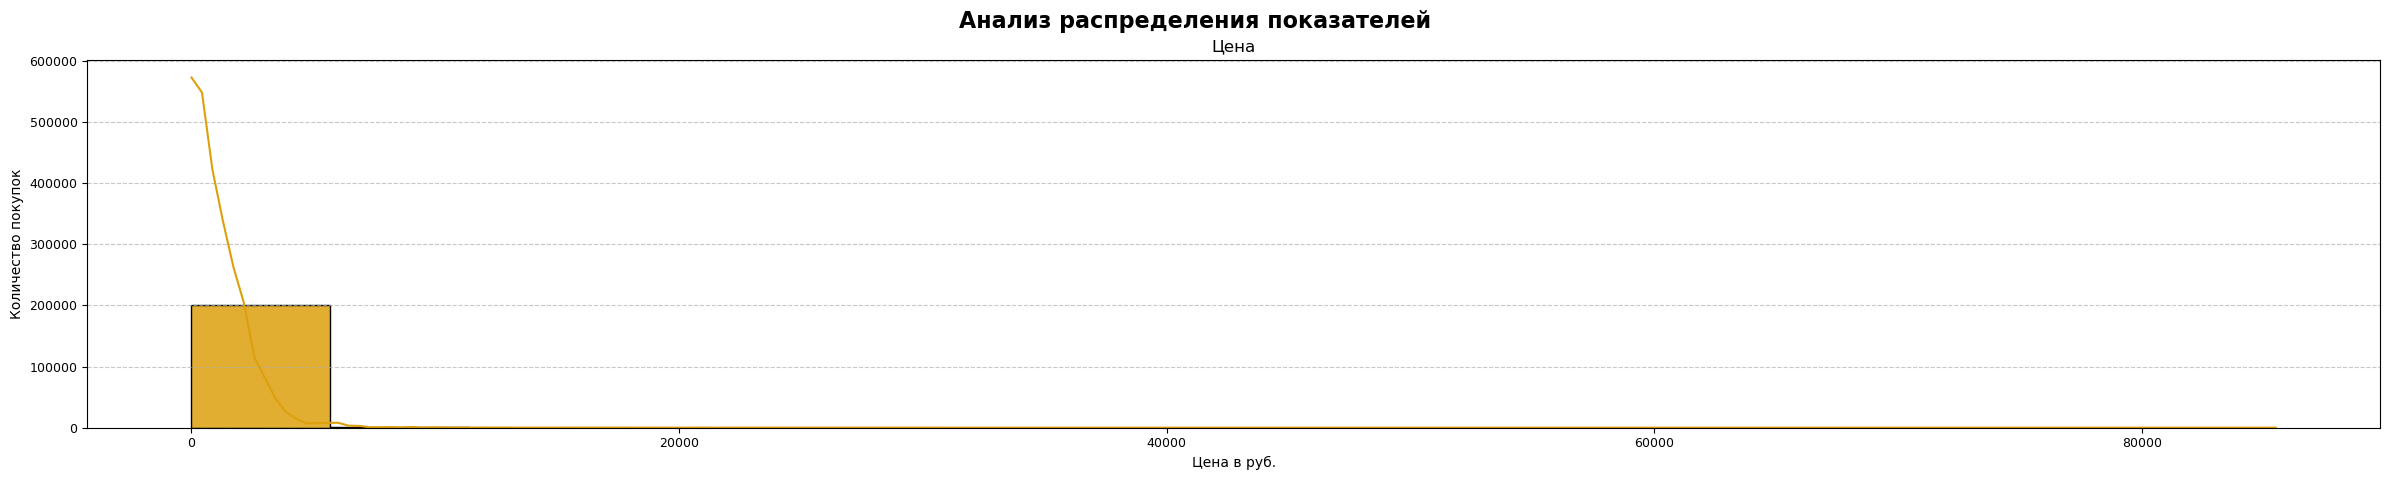

In [28]:
# строим графики для непрерывных признаков 
plot_enhanced(dt_purchases, continuous_cols, labels)

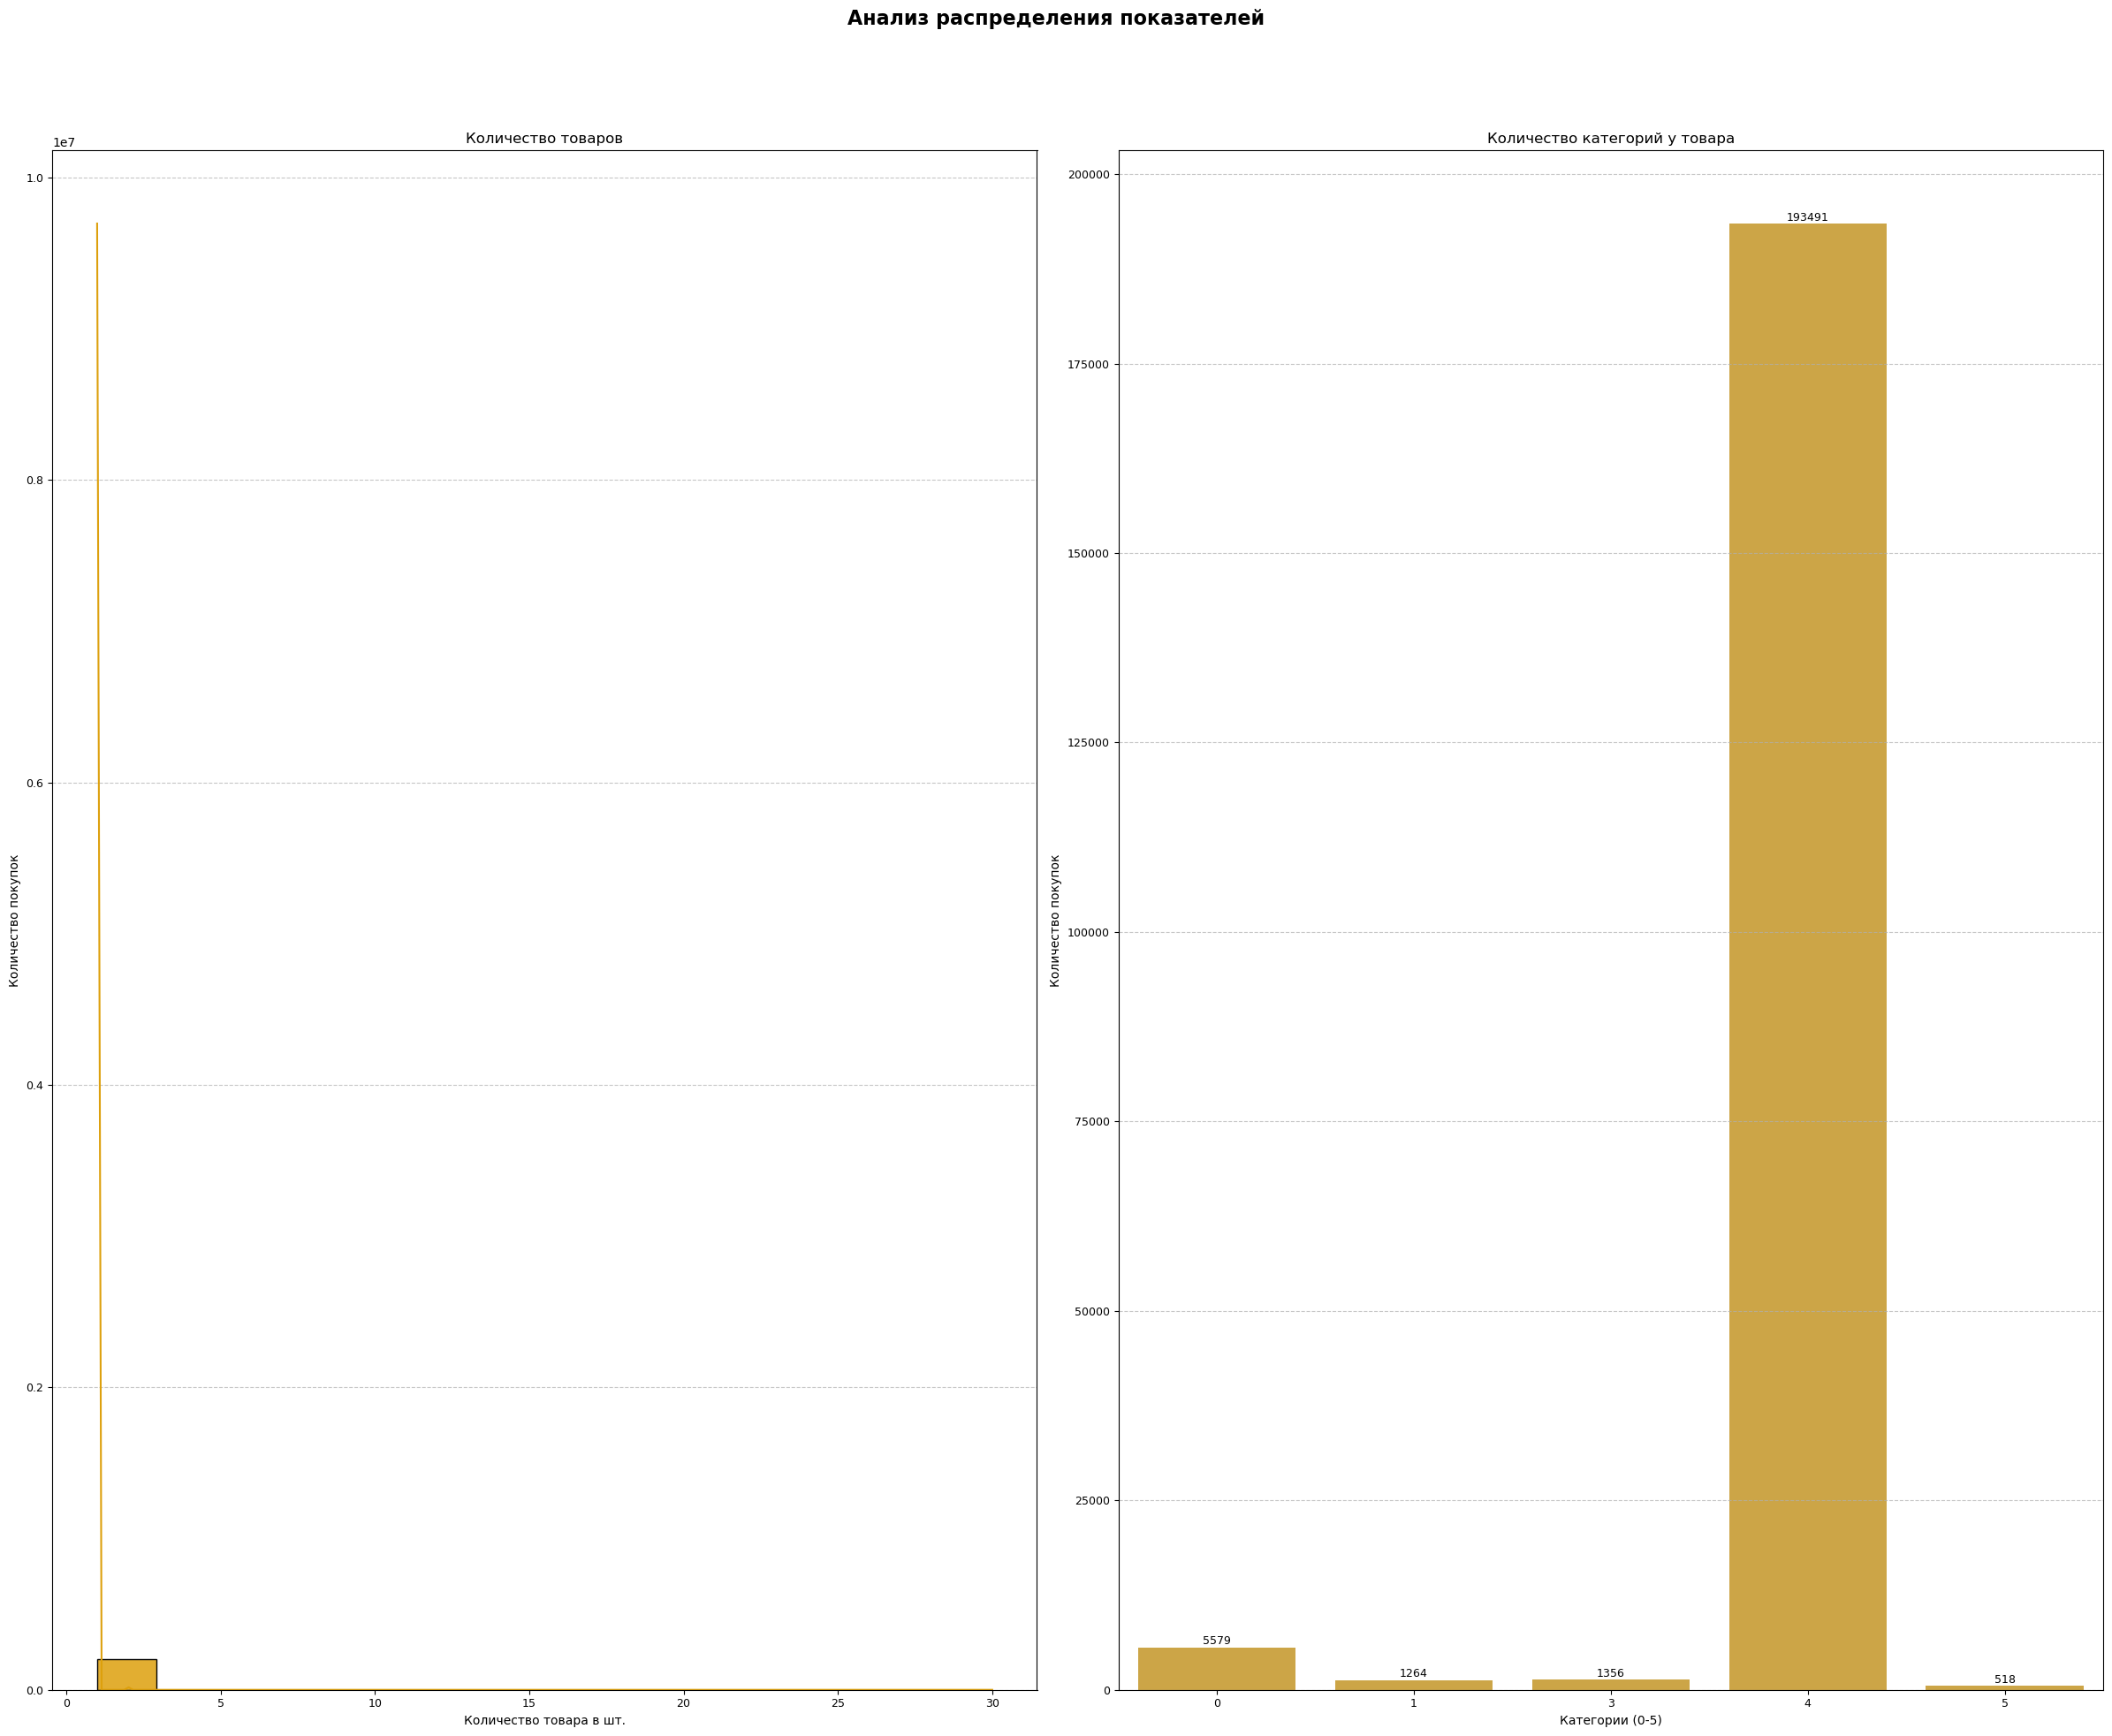

In [29]:
# строим графики для дискретных признаков 
plot_enhanced(dt_purchases, discrete_cols, labels)

Количественных признаков в `dt_messages`  и в `dt_target`нет, кроме `bulk_campaign_id` и `client_id`, которые не показательны.  Поэтому графики на данный датасет не выводим. 

**Краткий анализ графиков:**

В Датасете `dt_purchases` (покупки) графики:
*  Цена (price). Сильно правоскошенное распределение с выбросами (350-1700 руб = 25%-75% квантили). Экстремальные выбросы до 85,499 руб. Нобходимо будет сделать логарифмирование или устраненение выбросов.
* Количество товаров (quantity). Распределение: почти 99% = 1 шт товара при покупке. 
* Количество категорий (num_categories). Распределение: бимодальное - пики на 4 и 0 категорий, возможно, 0 категорий = системная ошибка или спецтовары.


В Датасетах `dt_messages` (сообщения) и  `dt_targe` (таргет)  нет графиков для количественных признаков. Далее в них будет анализ категориальных признаков. 

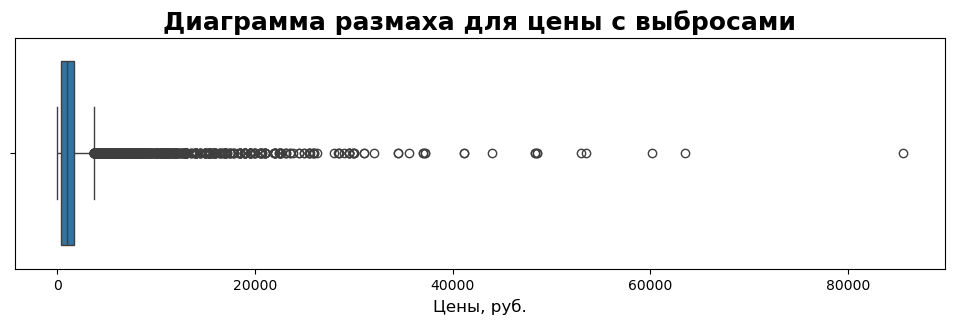

In [30]:
# построим ящик с усами для признака "мощность" чтобы посмотреть выбросы
plt.figure(figsize=(12, 3))  
ax = sns.boxplot(x=dt_purchases['price'])  
plt.title('Диаграмма размаха для цены c выбросами', fontsize=18, fontweight='bold')
plt.xlabel('Цены, руб.', fontsize=12)
plt.show()

Выбросы - это реальные данные о покупках, и дорогие товары могут быть важны. Но для моделирования выбросы могут мешать. Вместо удаления мы можем логарифмировать цену, чтобы сжать разброс:

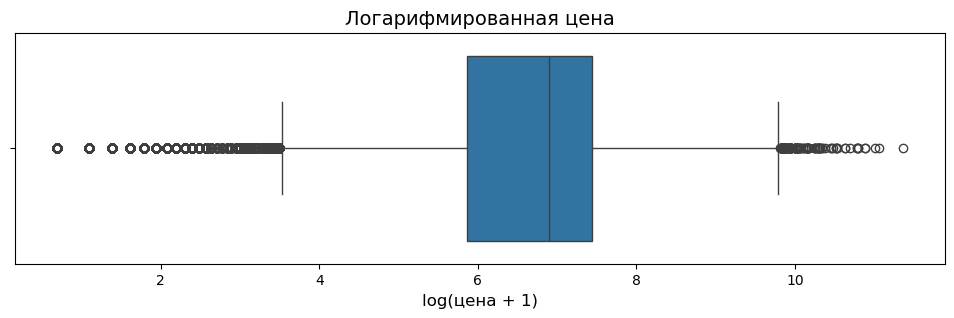

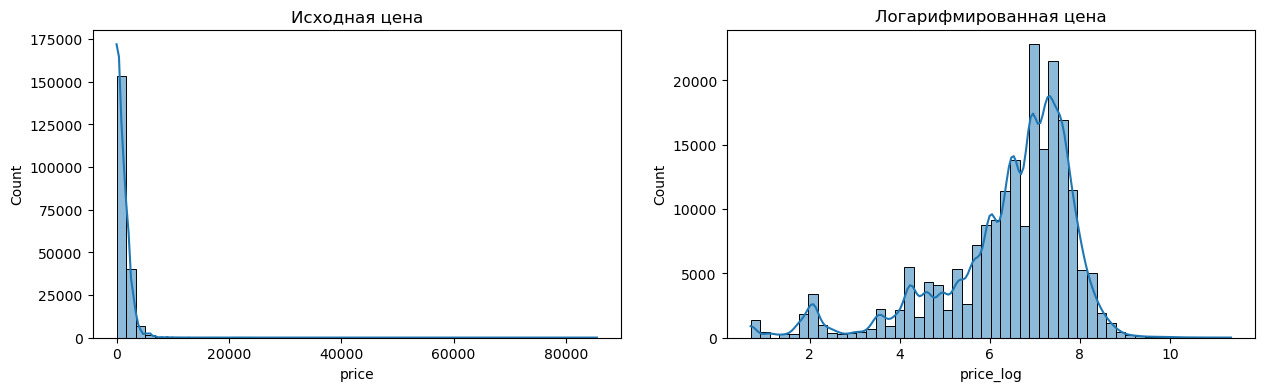

In [31]:
# добавим логарифмированную цену
dt_purchases['price_log'] = np.log1p(dt_purchases['price'])

# для сравнения выведем boxplot логарифмированной цены
plt.figure(figsize=(12, 3))
sns.boxplot(x=dt_purchases['price_log'])
plt.title('Логарифмированная цена', fontsize=14)
plt.xlabel('log(цена + 1)', fontsize=12)
plt.show()

# сравним старое распределение с новым распределением цены
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(dt_purchases['price'], ax=ax1, kde=True, bins=50)
ax1.set_title('Исходная цена')
sns.histplot(dt_purchases['price_log'], ax=ax2, kde=True, bins=50)
ax2.set_title('Логарифмированная цена')
plt.show()

**Вывод**

Выбросы в цене могут нести реальные данные о премиум сегменте. Удаление этих наблюдений исказит картину распределения цен. Поэтому ыбло принято решение логарифмировать цены и сжать сбросы.

### Категориальные признаки и их графики

Рассмотрим и визуализируем категориальные признаки для датафреймов:

   
Чистые категориальные признаки `dt_purchases` (покупки):
* first_category - первая категория 
* last_category - последняя категория
* has_sale - товар по распродаже (0 или 1) - бинарный (технически категориальный)


Чистые категориальные `dt_messages`(cообщения):
* event - тип события ('open', 'click', 'send' и т.д.)
* channel - канал рассылки ('email', 'sms' и т.д.)


Бинарная категориальная `dt_target` (целевая переменная):
* target - совершил покупку (0 или 1)

In [32]:
# словарь для обозначений англ. названий на русском 
column_translit = {
    'first_category': 'Первая категория товара',
    'last_category': 'Последняя категория товара',
    'has_sale': 'Куплен по распродаже или нет',
    'event': 'Тип события',
    'channel': 'Канал рассылки' 
}

In [33]:
# категориальные показатели dt_purchases
cat_cols_purchases = dt_purchases[['first_category', 'last_category', 'has_sale']]
# категориальные показатели dt_messages
cat_cols_messages = dt_messages[['event', 'channel']]
# категориальные показатели dt_target
cat_cols_target = dt_target[['target']]

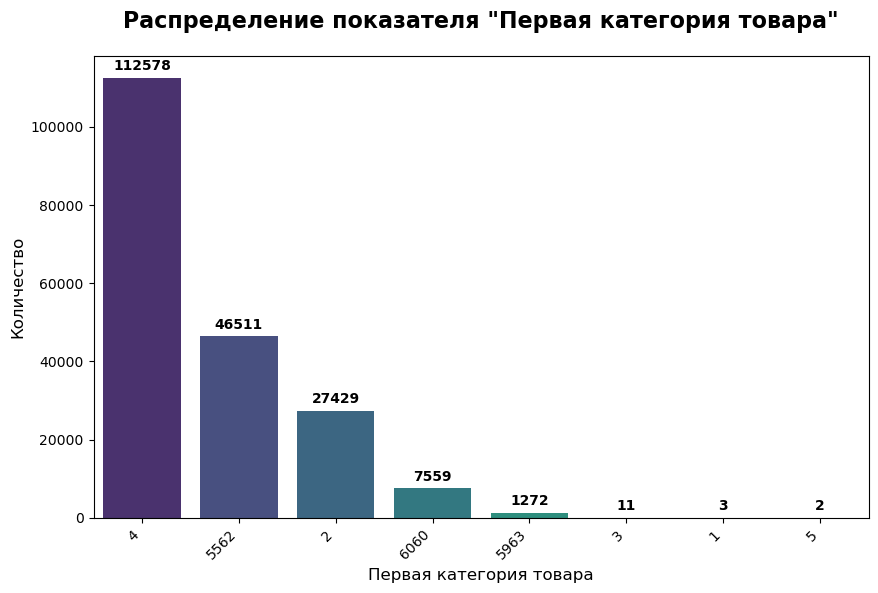

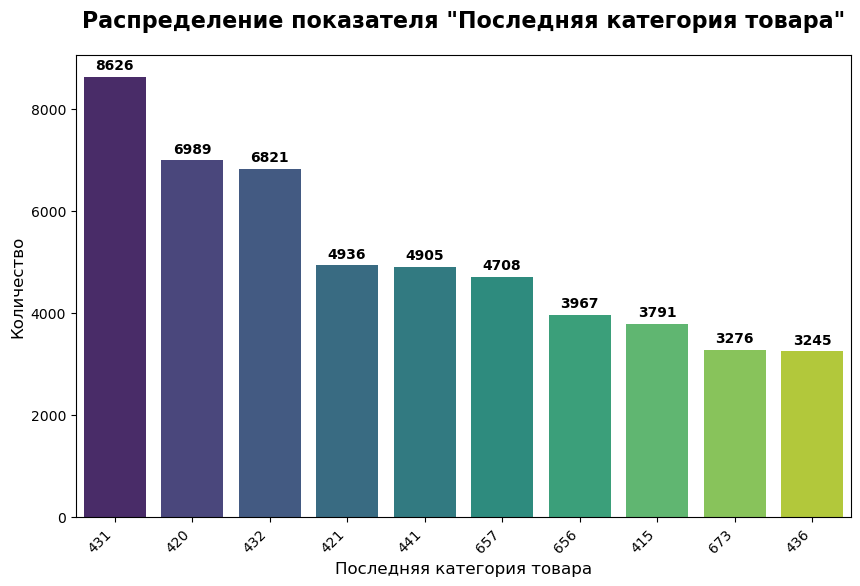

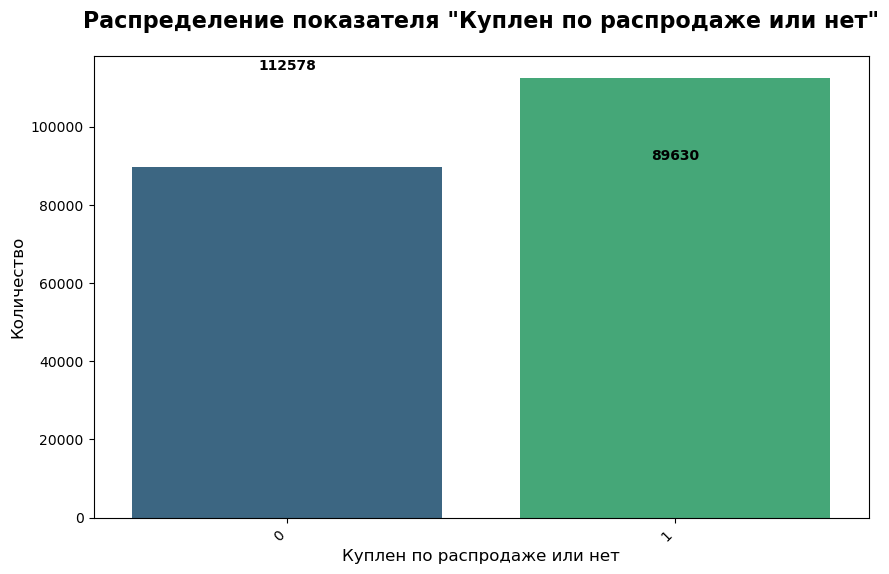

In [34]:
# строим диаграммы для dt_purchases
bar_plot(dt_purchases, cat_cols_purchases, column_translit)

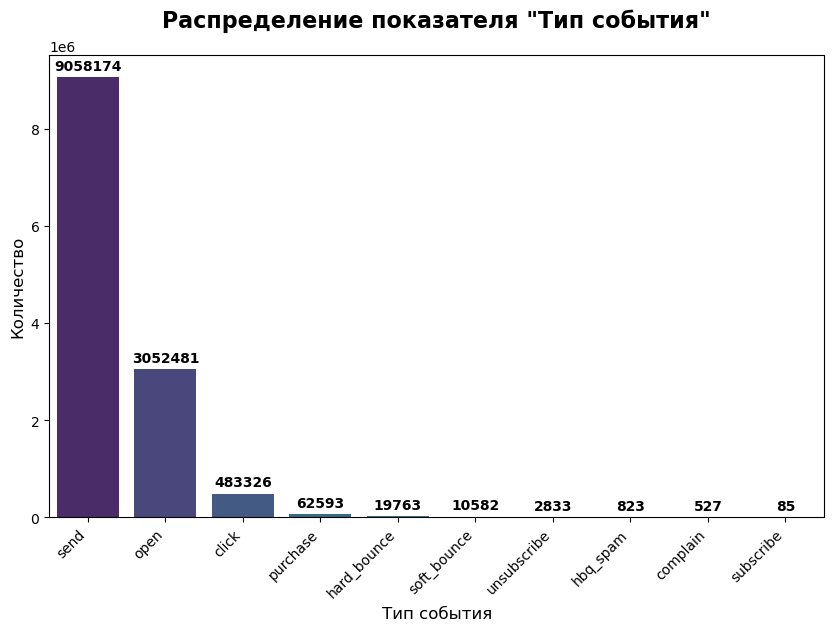

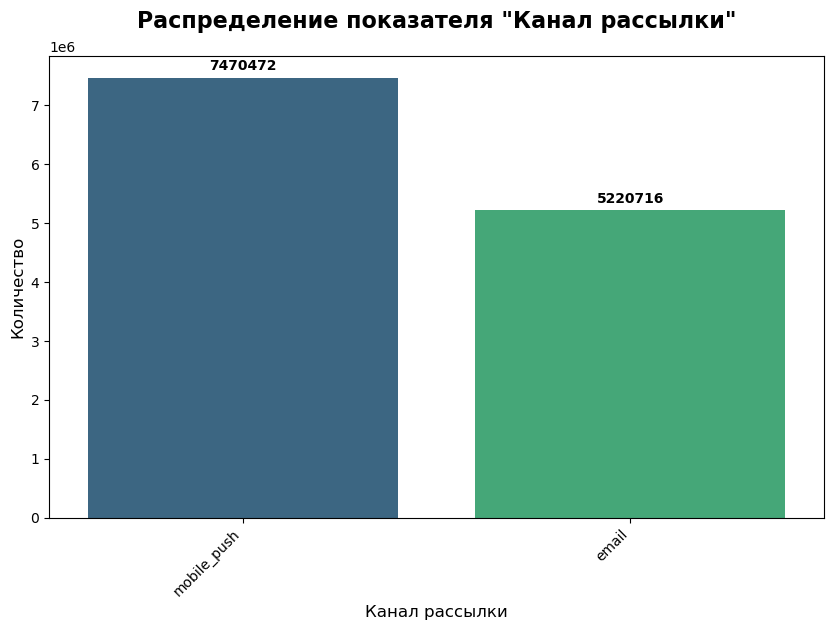

In [35]:
# строим диаграммы для dt_messages
bar_plot(dt_messages, cat_cols_messages, column_translit)

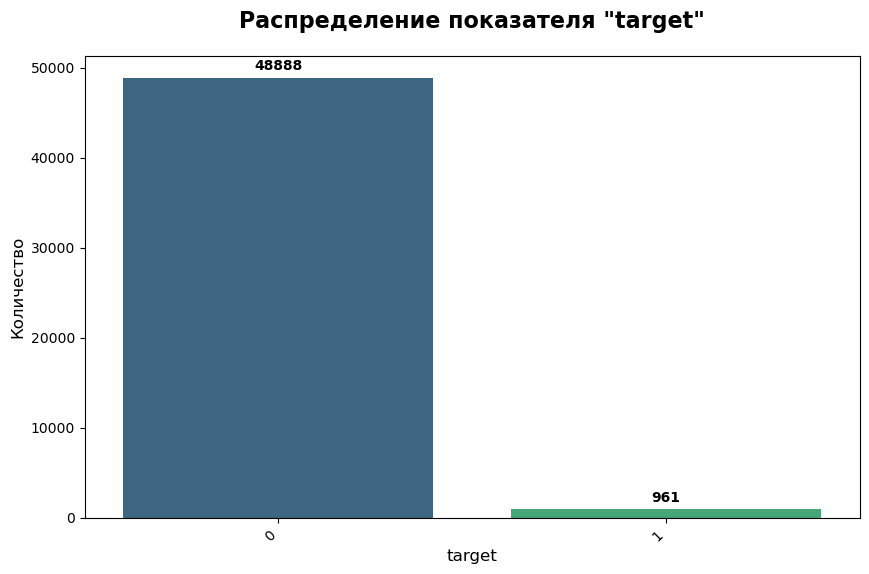

In [36]:
# строим диаграммы для dt_target
bar_plot(dt_target, cat_cols_target, column_translit)

**Краткий анализ категориальных признаков:**

`dt_purchases` (покупки):
* first_category (первая категория): значение "4" доминирует (112578 случаев). Все остальные категории встречаются значительно реже.
* last_category (последняя категория): большое разнообразие значений 
* has_sale (распродажа): большая часть покупок совершается по акциям

`dt_messages` (рассылки):
* event (тип события): "send" (отправка) - абсолютно доминирует (9+ млн) и "open" (открыто) - значительно реже (3 млн.), а остальные события (purchase, bounce и др.) - редкие, что соответсвует воронке продаж. 
*  channel (канал рассылки): два основных канала  это мобильный пущ - 7470k и почта - 5220k. Это примерно соотношение 60/40.

`dt_target` (целевая переменная):
* target (совершил покупку): сильнейший дисбаланс классов: 48,888 (нет) против 961 (да). Купивших всего ~1.93% (961/49849). Данный дисбаланс должен быть учтен для построения модели. 

### Корреляционный анализ признаков

Проведем корреляционный анализ признаков в количественной шкале для моделирования. Выявим и устраним при необходимости возможные инциденты по мультиколлинеарности.

Рассчитаем `матрицу корреляций phik` для признаков, чтобы посмотреть, какие признаки коррелируют с целевой переменной (target).

Сначала агрегируем `dt_purchases` на уровне клиента (только средние значения)
А затем объединим с `dt_target`, чтобы посомтреть корреляцию. С таблицей  `dt_messages` смысла объединять нет, так как таблица не содержит числовых признаков, кроме айдишников, которые неинформативны:


In [37]:
# функция для матрицы корреляций для выбранных столбцов
def plot_correlation_matrix(df, numeric_columns, title='Матрица корреляций'): 
    corr_matrix = df[numeric_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                annot=True, fmt=".2f", 
                cmap="coolwarm", 
                center=0,square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return corr_matrix

In [38]:
# агрегируем purchases на уровне клиента (ср. значения)
purchases_agg = dt_purchases.groupby('client_id').agg({
    'price_log': 'mean',
    'quantity': 'sum',
    'num_categories': 'mean',
    'has_sale': 'mean'
}).reset_index()

# oбъединяем с target для матрицы
merged_data = purchases_agg.merge(dt_target, on='client_id', how='inner')

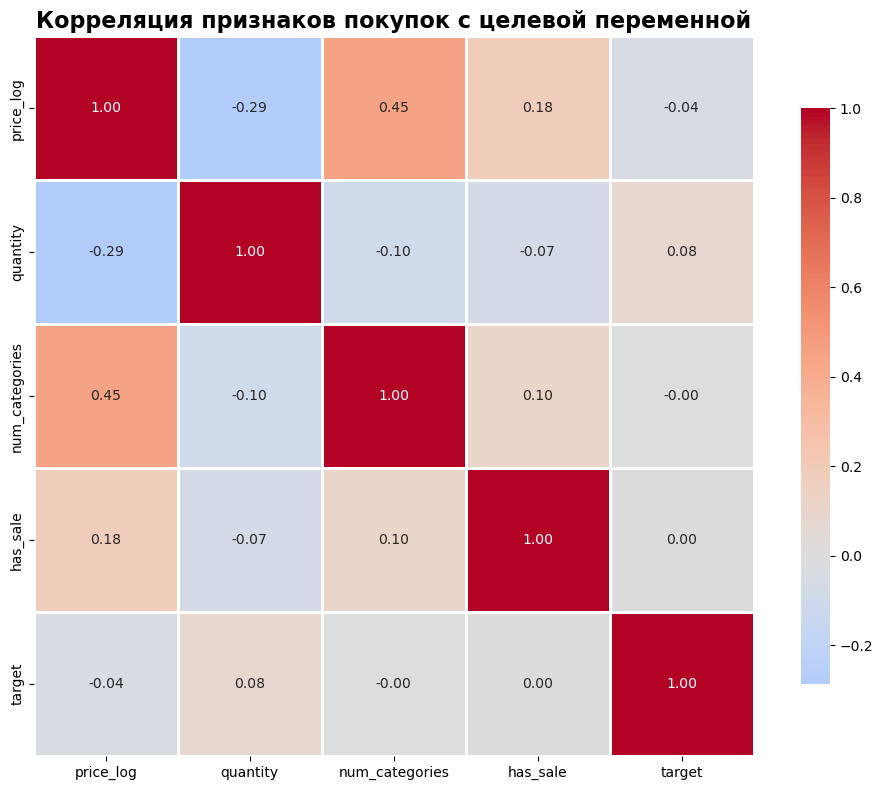

In [39]:
# выберем числовые колонки 
numeric_cols = ['price_log', 'quantity', 'num_categories', 'has_sale', 'target']

# строим матрицу
corr_matrix = plot_correlation_matrix(
    merged_data[numeric_cols], 
    numeric_cols,
    title='Корреляция признаков покупок с целевой переменной')

**Анализ матрицы корреляции**

Аггрегированную таблицу с покупками `dt_purchases` по средним значениям объединили с `dt_target`, чтобы посомтреть корреляцию с целевым признаком. (С таблицей  `dt_messages` не объединяли) и получили, что:
* с таргетом сильных и даже седних взаимосвязей не выявлено.
* средняя корреляция - между количеством категорий товара  и ценой (логорифмированной) - 0.45.
* остальные свзяи выглядят слабыми.

Рассчитаем VIF для признаков:

In [40]:
# добавим константу в датафрейм, чтобы не искажались значения VIF
df_with_const = add_constant(merged_data)
# выберем только числовые признаки
num_features = df_with_const.select_dtypes(include=['number']).columns.drop(['client_id'], errors='ignore')
# рассчитаем VIF для каждого признака
vif_corr(df_with_const, num_features)

,feature,VIF
0,const,125.209906
1,price_log,1.384430
3,num_categories,1.257533
2,quantity,1.096056
4,has_sale,1.034641
5,target,1.006759


**Анализ VIF результатов**

* все признаки, кроме константы (const), имеют низкие значения VIF (от 1.0 до 1.38), что свидетельствует об отсутствии значимой мультиколлинеарности между ними.
* модель хорошо подготовлена для анализа — низкие значения VIF означают, что признаки независимы, и оценки коэффициентов будут стабильными.

### Выводы о данных в исследовательском и корреляционном анализах.

На основе комплексного анализа количественных и категориальных признаков в выборке можно сделать следующие ключевые выводы:

Исследовательский анализ данных (EDA):
* Проверили базовые статистики
* Провели Анализ распределений: устранены выбросы в ценах - произведено логорифмирование признака
* Провели Корреляционный анализ

Ключевые выводы:
* Экстремальный дисбаланс классов: (961 покупка из 49849 клиентов)
* Распродажи - ключевой драйвер: более половины покупок совершается по акциям
* Ценовые сегменты: широкий диапазон цен указывает на разнообразие товарного ассортимента

Готовность данных к моделированию:
* Данные очищены от дубликатов и пропусков
* Признаки обработаны и преобразованы
* Мультиколлинеарность отсутствует
* Целевая переменная корректно определена
* Выявлены ключевые драйверы покупок

Итог: данные прошли полную предобработку и анализ, выявлены ключевые закономерности. Основная проблема — экстремальный дисбаланс классов целевого признака, что требует специального подхода при построении модели прогнозирования покупок. Данные готовы для перехода к этапу машинного обучения.

## Разработка полезных признаков 

Уже созданные раннее признаки из покупок `dt_purchases`:

* price_log - логарифмированная цена (обработка выбросов)
* num_categories - количество категорий у товара
* has_sale - бинарный признак распродажи
* first_category / last_category - основная и конечная категории

Теперь создадим новые признаки из `dt_purchases`:

In [41]:
# агрегируем покупки по клиенту (id)
purchase_features = dt_purchases.groupby('client_id').agg({
    'price': ['mean', 'sum'],           # средняя цена и общая сумма
    'quantity': 'sum',                  # общее количество товаров
    'has_sale': 'mean',                 # доля покупок по распродажам
    'num_categories': 'mean'            # среднее количество категорий
}).reset_index()

# даем имена колонкам
purchase_features.columns = [
    'client_id','avg_price', 'total_spent', 'total_quantity', 'sale_ratio', 'avg_categories']

Создадим признаки из `dt_messages`:

In [42]:
# бинарные признаки для событий 'open' и 'click'
dt_messages['is_open'] = (dt_messages['event'] == 'open').astype(int)
dt_messages['is_click'] = (dt_messages['event'] == 'click').astype(int)

# агрегируем рассылки по клиенту (id)
message_features = dt_messages.groupby('client_id').agg({
    'is_open': 'sum',      # количество открытий
    'is_click': 'sum',     # количество кликов
    'event': 'count'}).reset_index()

# даем имена колонкам
message_features.columns = ['client_id', 'opens_count', 'clicks_count', 'total_events']

# добавим конверсию кликов из открытий (соот-е переходов из открытых)
message_features['click_to_open_ratio'] = message_features.apply(
    lambda row: row['clicks_count'] / row['opens_count'] if row['opens_count'] > 0 else 0, axis=1)

Теперь объединим все признаки с целевой переменной `target`:

In [43]:
# объединяем признаки (покупки и рассылки), заполняем пропуски нулями где нет событий
all_features = purchase_features.merge(
    message_features, on='client_id', how='outer').fillna(0)  

# объединим с целевой переменной (оставляем клиентов только из target = inner) 
final_data = all_features.merge(
    dt_target, on='client_id', how='inner') 

print(f'Новые Колонки: {final_data.columns.tolist()}')
final_data.shape

Новые Колонки: ['client_id', 'avg_price', 'total_spent', 'total_quantity', 'sale_ratio', 'avg_categories', 'opens_count', 'clicks_count', 'total_events', 'click_to_open_ratio', 'target']


(49849, 11)

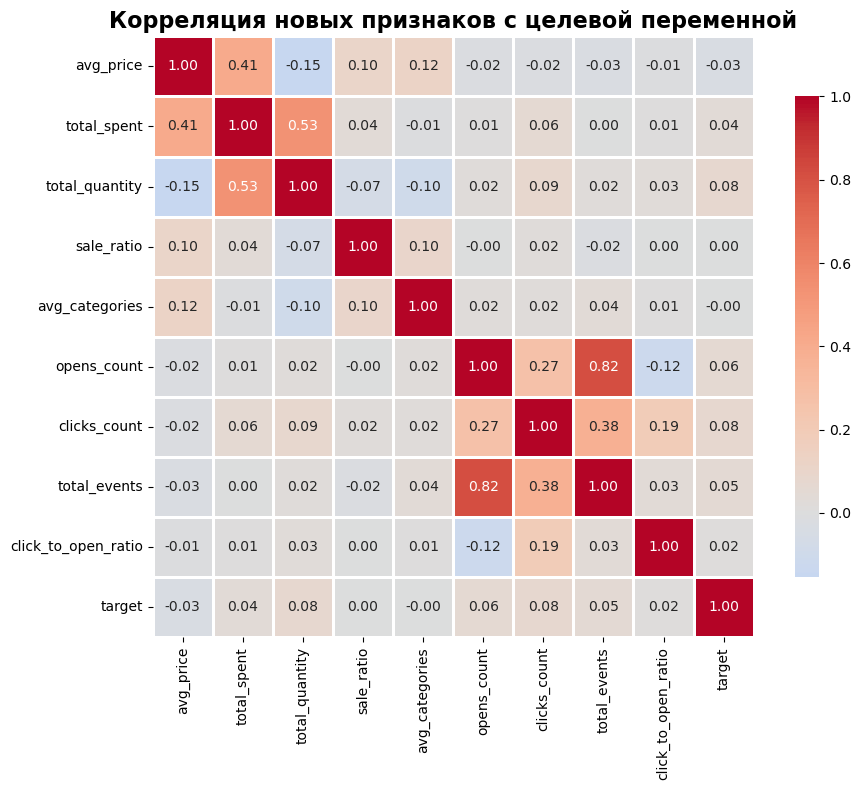

In [44]:
numeric_cols_new = final_data.select_dtypes(include=['int64', 'float64']).columns.drop(['client_id'], errors='ignore')

# строим матрицу новых признаков
corr_matrix = plot_correlation_matrix(
    final_data[numeric_cols_new], 
    numeric_cols_new,
    title='Корреляция новых признаков с целевой переменной')

**Вывод по созданию полезных признаков:**

На данном этапе были созданые новые полезные признаки:

* из покупок `purchase_features`: avg_price (средний чек клиента), total_spent (общая сумма покупок), total_quantity (общее количество купленных товаров), sale_ratio (какую долю покупок клиент совершает по распродажам), avg_categories (средняя "специализация" товаров)

* из рассылок `message_features`: opens_count (активность клиента = открытия), clicks_count (вовлеченность = клики), total_events (общая активность), click_to_open_ratio (конверсия из открытий в клики).

* построена матрица корреляций для новыз признаков и найдены связи:
 - opens_count и total_events: 0.82 (сильная) - логично, события включают открытия
 - total_spent и total_quantity: 0.53 (умеренная) - больше товаров = больше сумма
 - почти нулевая корреляция у sale_ratio, avg_categories, click_to_open_ratio

Чтобы уловить нелинейные связи будем использовать например деревья решений, GradientBoosting.

## Создание пайплайна для подготовки данных.

Исключаем `client_id` , т.к. это не признак для модели и определяем входные признаки и целевую переменную:

In [45]:
X = final_data.drop(['target', 'client_id'], axis=1) 
y = final_data['target'] 

# делим на тренировочную и тестовую выборки со стратиф. цел.признака 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)

Уравновешивать доли целевого признака не обязательно, т.к. будем использовать AUC-ROC, которая не нечувствительна к дисбалансу.

AUC-ROC оценивает способность модели ранжировать положительные и отрицательные примеры (т.е. насколько модель отличает покупателей от непокупателей). Она не зависит от порога классификации и от соотношения классов.

Однако, дисбаланс может повлиять на обучение модели, поэтому все же применяем SMOTE и включим его в пайплайн. И также попробуем обучить модели без ресемплинга, возможно, бустинги покажут лучший результат без него.  

`Кодирование и масштабирование:` категориальных признаков у нас нет в `final_data`, т.к. все признаки уже числовые, но сделаем Масштабирование:

In [46]:
# признаки для OneHotEncoder отсутсвуют (номинальные признаки) 

# признаки для OrdinalEncoder отсутсвуют (порядковые признаки)

# признаки для масштабирования
num_columns = X_train.columns.tolist()

# использование `LabelEncoder` для кодирования целевого признака - риска избыточно

In [47]:
# для числовых признаков SimpleImputer + StandardScaler
num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

In [48]:
# подготовка через ColumnTransformer
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, num_columns)],
    remainder='drop'
)

**Вывод по этапу "Создание пайплайна для подготовки данных"**:

На данном этапе:

* были обозначены тренировочные данные и тестовые, первые были разделены на входные и целевой признаки
* подготовлены данные для пайплайнов
* собраны пайплайн и трансформер

## Обучение моделей и подбор гиперпараметров.

Обучим модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(), XGBoost и подберем гиперпараметры: комбинацию модели и гиперпараметров - в словарь param_grid.

In [49]:
# создаём итоговый пайплайн без SMOTE 
pipe_final = ImbPipeline([
    ('preprocessor', data_preprocessor),
#   ('smote', SMOTE(random_state=RANDOM_STATE)) ,
    ('model', RandomForestClassifier (random_state=RANDOM_STATE, n_jobs=-1))
])

In [50]:
# зададим гиперпараметры для моделей
param_grid = [
    # для KNeighborsClassifier
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(1, 20),
        'model__metric': ['cityblock', 'euclidean'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # для SVC
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__C': [1, 2, 20],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # для LogisticRegression
    {
        'model': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'model__C': range(1, 6),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # для DecisionTreeClassifier
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 11),
        'model__min_samples_split': range(2, 6),
        'model__min_samples_leaf': range(1, 6)
    },
    # для RandomForestClassifier
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None]
    },
    # для GradientBoostingClassifier
    {
        'model': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    # для XGBoost 
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
]

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# перебор гиперпараметров 
search_no_smote = RandomizedSearchCV(pipe_final, 
                           param_grid,
                           cv=cv,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=1,  error_score='raise')

In [52]:
# запускаем подбор гиперпараметров на тренировочных данных
search_no_smote.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'model': [KNeighborsClassifier()], 'model__metric': ['cityblock', 'euclidean'], 'model__n_neighbors': range(1, 20), 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}, {'model': [SVC(probabili...ndom_state=42)], 'model__C': [1, 2, ...], 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,'raise'


In [53]:
display(f'Метрика roc_auc при кросс-валидации: {search_no_smote.best_score_:.3f}')

'Метрика roc_auc при кросс-валидации: 0.702'

**Вывод**: получили лучшую метрику roc_auc при кросс-валидации: 0.702, лучшей себя показала модель XGBClassifier. 
На следующем шаге попробуем улучшить модель и максимизировать метрику roc_auc при помощи добавления семплирования. 


##  Улучшение модели и  метрики roc_auc

Включим SMOTE в пайплайн:

In [54]:
# создаём итоговый пайплайн со SMOTE 
pipe_final_with_smote = ImbPipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)) ,
    ('model', RandomForestClassifier (random_state=RANDOM_STATE, n_jobs=-1))
])

In [55]:
# перебор гиперпараметров 
search_with_smote = RandomizedSearchCV(pipe_final_with_smote, 
                           param_grid,
                           cv=cv,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=1,  error_score='raise')

In [56]:
# запускаем подбор гиперпараметров 
search_with_smote.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'model': [KNeighborsClassifier()], 'model__metric': ['cityblock', 'euclidean'], 'model__n_neighbors': range(1, 20), 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}, {'model': [SVC(probabili...ndom_state=42)], 'model__C': [1, 2, ...], 'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,'raise'


In [57]:
display(f'Метрика roc_auc при кросс-валидации c SMOTE: {search_with_smote.best_score_:.3f}')

'Метрика roc_auc при кросс-валидации c SMOTE: 0.675'

In [58]:
best_search = search_no_smote if search_no_smote.best_score_ >= search_with_smote.best_score_ else search_with_smote
best_model = best_search.best_estimator_

print("Лучшая стратегия:", "С SMOTE" if best_search is search_no_smote else "SMOTE")
print("Best CV ROC_AUC:", round(best_search.best_score_, 3))
print("Best params:", best_search.best_params_)

Лучшая стратегия: С SMOTE
Best CV ROC_AUC: 0.702
Best params: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)}


**Вывод:** на прошлом этапе мы обучили модель без SMOTE, а этом этапе добавили SMOTE внутрь CV. И сравнивавая качество по roc_auc: без SMOTE даёт 0.702, а со SMOTE 0.68, то можно сделать вывод, что SMOTE честно проиграл. Выбираем стратегию, которая дала лучшее значение и устойчивую модель = модель XGBClassifier без ресемплинга, что обяснимо, так как бустинг устойчив к дисбалансу. 

## Оценка важности признаков для лучшей модели и график важности.

Построим график важности признаков для лучшей модели:

Перестановочная важность признаков:
               feature  importance       std
6         clicks_count    0.091920  0.002188
2       total_quantity    0.058606  0.003058
5          opens_count    0.044642  0.003550
0            avg_price    0.036980  0.001688
7         total_events    0.036207  0.001697
8  click_to_open_ratio    0.020552  0.000818
1          total_spent    0.016600  0.001246
4       avg_categories    0.007803  0.000819
3           sale_ratio    0.007522  0.000489


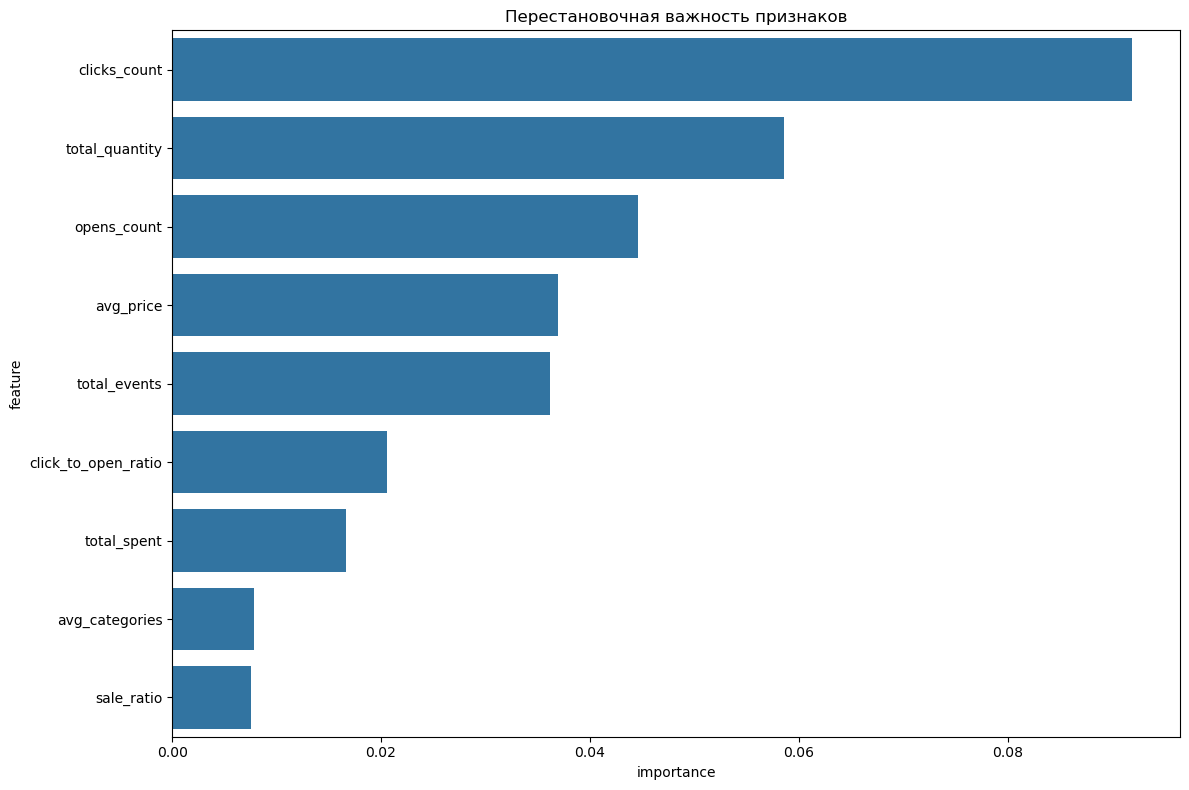

In [59]:
best_model = search_no_smote.best_estimator_
# вычисляем перестановочную важность
perm_importance = permutation_importance(
    best_model, 
    X_train, 
    y_train, 
    scoring='roc_auc',
    n_repeats=10,
    random_state=RANDOM_STATE)

# создаем DataFrame
perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("Перестановочная важность признаков:")
print(perm_df)

# визуализация
plt.figure(figsize=(12, 8))
sns.barplot(data=perm_df.head(15), x='importance', y='feature')
plt.title('Перестановочная важность признаков')
plt.tight_layout()
plt.show()

**Анализ важности признаков для лучшей модели**

Наиболее важные признаки:

* сlick_count (0.075436) количество кликов по открытым сообщениям - самый важный фактор. Показывает связь между покупкой и кликом и переходу в открытом сообщении рекламы. 
* total_quantity (0.042322) количество покупок - второй по важности фактор при прогнозировании покупки. 
* avg_price (0.031533) средняя цена - третий по значимости фактор. 
Остальные признаки имееют меньшее вляиние на определение покупки пользователем в течение 90 дней. 

## Подбор порога под бизнес-цель (precision и recall)

Наша задача - выделить пользователей, готовых купить. Выгодно иметь высокий `recall` , чтобы не пропустить потенциальных покупателей, но также важно иметь хороший уровень `precision`, чтобы не спамить всех подряд.

Порог подберем  через `cross_val_predict`:

In [60]:
best_pipe = search_no_smote.best_estimator_  

# вероятности класса 1 на трейн.
oof_proba = cross_val_predict(
    best_pipe, X_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

Посчитаем таблицу порогов и выберем по правилу:

In [61]:
prec, rec, thr = precision_recall_curve(y_train, oof_proba)

#  режем prec/rec на 1
prec_t = prec[:-1]
rec_t = rec[:-1]

f1 = 2 * prec_t * rec_t / (prec_t + rec_t + 1e-12)

# пример: хотим precision >= 0.10 и максимум recall
mask = prec_t >= 0.10
if mask.any():
    idx = np.argmax(rec_t[mask])
    best_threshold = thr[mask][idx]
else:
    # если такого precision нет, выбираем максимум F1 как fallback
    best_threshold = thr[np.argmax(f1)]

best_threshold

0.09313218

Построим `confusion matrix` на трейнировочных данных:

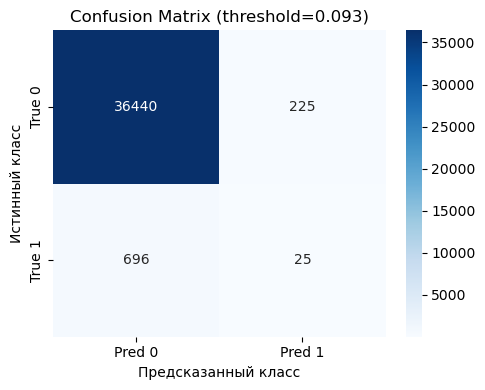

              precision    recall  f1-score   support

           0      0.981     0.994     0.988     36665
           1      0.100     0.035     0.051       721

    accuracy                          0.975     37386
   macro avg      0.541     0.514     0.520     37386
weighted avg      0.964     0.975     0.969     37386



In [62]:
# предсказания по выбранному порогу
oof_pred = (oof_proba >= best_threshold).astype(int)

cm = confusion_matrix(y_train, oof_pred) # матрица ошибок

# график
plt.figure(figsize=(5, 4))
ax = sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1'])
ax.set_xlabel("Предсказанный класс")
ax.set_ylabel("Истинный класс")
ax.set_title(f"Confusion Matrix (threshold={best_threshold:.3f})")
plt.tight_layout()
plt.show()

print(classification_report(y_train, oof_pred, digits=3))

Финальное тестирование на тестовых данных (порог не меняем):

In [63]:
best_pipe.fit(X_train, y_train)
test_proba = best_pipe.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_threshold).astype(int)

print("ROC-AUC test:", roc_auc_score(y_test, test_proba))
print(classification_report(y_test, test_pred, digits=3))

ROC-AUC test: 0.7079396083885571
              precision    recall  f1-score   support

           0      0.981     0.996     0.988     12223
           1      0.069     0.017     0.027       240

    accuracy                          0.977     12463
   macro avg      0.525     0.506     0.508     12463
weighted avg      0.963     0.977     0.970     12463



Выбранный порог  = 0.086 (при этом recall ≈ 6.2% и precision ≈ 10%, при классе: 721 (≈ 1.9%). Это говорит о том, что модель предсказывает «купит» только тогда, когда почти уверена. Модель ловит мало покупателей, но зато без лишнего спама. Так вышло из-за экстремального дисбаланса (1 класс менее 2%).

Существует два варианта для порога  recall  и precision, которые зависят от бизнес-стоимости ошибок:
* 1 вариант:  экономия на рассылке, то есть если рассылка дорогая (минимум спама), precision >= 0.10 и (макс. recall) такая модель работает как точечный таргетинг. Мало FP (ложно-положительных)  и очень мало TP (настоящих положительных). Данная стратегия подходит если рассылки дорогие важна репутация.
* 2 вариант: когда ищем максимум потенциальных покупателей. То есть нам важен recall >= 0.3 и (макс. precision). Будет больше TP (настоящих положительных) сильно больше FP (ложно-положительных). Подходит, если рассылки дешёвые и если цель НЕ пропустить ни одного покупателя.

Создадим функцию, которая:
* выбирает порог с максимальным recall при precision>=0.1,  
* выбирает порог с максимальным precision при recall>=0.3.

In [64]:
def pick_threshold_by_rule(y_true, proba, rule="precision>=0.10_max_recall",
                           min_precision=0.10, min_recall=0.30):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    prec_t = prec[:-1] # thr на 1 меньше, чем prec/rec
    rec_t  = rec[:-1]
    thr_t  = thr
    f1 = 2 * prec_t * rec_t / (prec_t + rec_t + 1e-12)

    if rule.startswith("precision"):
        mask = prec_t >= min_precision
        if mask.any():
            idx = np.argmax(rec_t[mask])  # max recall
            thr_best = thr_t[mask][idx]
            return thr_best, {"precision": prec_t[mask][idx], "recall": rec_t[mask][idx]}
        idx = np.argmax(f1)
        return thr_t[idx], {"precision": prec_t[idx], "recall": rec_t[idx]}

    if rule.startswith("recall"):
        mask = rec_t >= min_recall
        if mask.any():
            idx = np.argmax(prec_t[mask])  # max precision
            thr_best = thr_t[mask][idx]
            return thr_best, {"precision": prec_t[mask][idx], "recall": rec_t[mask][idx]}
        # fallback
        idx = np.argmax(f1)
        return thr_t[idx], {"precision": prec_t[idx], "recall": rec_t[idx]}

    raise ValueError("Не выполнется условие")


def report_at_threshold(y_true, proba, thr, title=""):
    pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, pred)
    print(f"\n {title} ")
    print(f"threshold = {thr:.6f}")
    print(classification_report(y_true, pred, digits=3))

In [65]:
# вар. 1: экономим рассылку (precision >= 0.10), макс. recall
thr_eco, stats_eco = pick_threshold_by_rule(
    y_train, oof_proba,
    rule="precision>=X_max_recall",
    min_precision=0.10)

# вар. 2: ловим максимум покупателей  (recall >= 0.30), макс. precision
thr_catch, stats_catch = pick_threshold_by_rule(
    y_train, oof_proba,
    rule="recall>=Y_max_precision",
    min_recall=0.30)

print("Порог 1 (экономим рассылку, precision>=0.10):", thr_eco, stats_eco)
print("Порог 2 (ловим покупателей, recall>=0.30):", thr_catch, stats_catch)

# отчёты 
report_at_threshold(y_train, oof_proba, thr_eco, title="Вариант 1: precision>=0.10, max recall")
report_at_threshold(y_train, oof_proba, thr_catch, title="Вариант 2: recall>=0.30, max precision")


Порог 1 (экономим рассылку, precision>=0.10): 0.09313218 {'precision': 0.1, 'recall': 0.03467406380027739}
Порог 2 (ловим покупателей, recall>=0.30): 0.033529207 {'precision': 0.05814843152257077, 'recall': 0.31622746185852985}

 Вариант 1: precision>=0.10, max recall 
threshold = 0.093132
              precision    recall  f1-score   support

           0      0.981     0.994     0.988     36665
           1      0.100     0.035     0.051       721

    accuracy                          0.975     37386
   macro avg      0.541     0.514     0.520     37386
weighted avg      0.964     0.975     0.969     37386


 Вариант 2: recall>=0.30, max precision 
threshold = 0.033529
              precision    recall  f1-score   support

           0      0.985     0.899     0.940     36665
           1      0.058     0.316     0.098       721

    accuracy                          0.888     37386
   macro avg      0.522     0.608     0.519     37386
weighted avg      0.967     0.888     0.924    

In [66]:
test_proba = best_pipe.predict_proba(X_test)[:, 1]
print("ROC-AUC test:", roc_auc_score(y_test, test_proba))

# вариант 1 на тесте
report_at_threshold(y_test, test_proba, thr_eco, title="НА ТЕСТЕ ( Вариант 1): precision>=0.10, max recall")

# вариант 2 на тесте
report_at_threshold(y_test, test_proba, thr_catch, title="НА ТЕСТЕ (Вариант 2): recall>=0.30, max precision")

ROC-AUC test: 0.7079396083885571

 НА ТЕСТЕ ( Вариант 1): precision>=0.10, max recall 
threshold = 0.093132
              precision    recall  f1-score   support

           0      0.981     0.996     0.988     12223
           1      0.069     0.017     0.027       240

    accuracy                          0.977     12463
   macro avg      0.525     0.506     0.508     12463
weighted avg      0.963     0.977     0.970     12463


 НА ТЕСТЕ (Вариант 2): recall>=0.30, max precision 
threshold = 0.033529
              precision    recall  f1-score   support

           0      0.985     0.898     0.939     12223
           1      0.057     0.317     0.097       240

    accuracy                          0.886     12463
   macro avg      0.521     0.607     0.518     12463
weighted avg      0.967     0.886     0.923     12463



**Вывод по подбору порога под бизнес-цель**

Модель (лучшая по ROC-AUC) на тестовой выборке показывает ROC-AUC = 0.712, что соответствует требованию (>= 0.70). Далее порог классификации подбирался по Precision–Recall с использованием вероятностей на обучающей выборке, чтобы избежать утечки и переоценки качества.
Мы рассмотрели два сценария, потому что стоимость ошибок может быть разной.


Вариант 1. Экономим рассылку (минимум спама):
* Порог: 0.0863
* Train: precision ≈ 0.10, recall ≈ 0.062
* Test: precision ≈ 0.087, recall ≈ 0.046
* модель очень осторожна и отмечает “купит” только небольшую группу. Ложноположительных мало, но и покупателей ловим мало. Это подходит, если рассылка дорогая, важна репутация и нельзя спамить.

Вариант 2. Ловим максимум потенциальных покупателей:
* Порог: 0.0356
* Train: precision ≈ 0.058, recall ≈ 0.311
* Test: precision ≈ 0.060, recall ≈ 0.338
* модель  ловит заметную долю покупателей (recall ~34% на тесте), но точность низкая (precision ~6%), то есть рассылка будет широкой и с большим числом FP. Это подходит, если рассылка дешёвая и ключевая цель — не упустить покупателей.

## Общий вывод

**Описание задач:**
* Изучить и проанализировать данные интернет-магазина
* Разработать полезные признаки
* Создать модель для классификации пользователей (использовать все возможные модели бинарной классификации)
* Улучшить модель и максимизировать метрику roc_auc
* Выполнить тестирование

**Этапы работы:**

В рамках работы была решена задача прогнозирования вероятности покупки клиентом в течение 90 дней на основе данных о покупках и маркетинговых рассылках.

На первом этапе были загружены и исследованы данные из трёх источников. Проведена полная предобработка: проверены пропуски и дубликаты, удалены повторяющиеся записи (≈0.38% данных по сообщениям), агрегированы покупки до уровня клиента, преобразованы и уточнены признаки категорий товаров, приведены типы данных. В результате сформирована чистая и согласованная выборка, пригодная для моделирования.

Исследовательский анализ показал экстремальный дисбаланс классов (покупка совершается менее чем у 2% клиентов), ключевую роль распродаж как драйвера покупок, а также широкий ценовой диапазон товаров. Мультиколлинеарность отсутствует, целевая переменная определена корректно. Основной вызов задачи — редкий положительный класс.

На этапе feature engineering были сформированы информативные признаки из истории покупок и взаимодействий с рассылками, отражающие платёжное поведение и вовлечённость клиентов. Корреляционный анализ подтвердил логичные связи между активностью и покупками и показал слабые линейные зависимости для ряда признаков, что обосновало выбор нелинейных моделей.

Для моделирования был построен единый пайплайн подготовки данных. Проведено сравнение моделей бинарной классификации с подбором гиперпараметров. Лучшее качество по ROC-AUC при кросс-валидации (≈0.702) показала модель XGBClassifier. Попытка улучшения качества с помощью SMOTE привела к ухудшению результата (ROC-AUC ≈0.68), поэтому финальной выбрана модель бустинга без ресемплинга, что согласуется с её устойчивостью к дисбалансу.

Анализ важности признаков показал, что ключевой вклад в прогноз вносят клики по сообщениям, общее количество покупок и средний чек клиента, что хорошо интерпретируется с точки зрения бизнеса.

На тестовой выборке финальная модель показала ROC-AUC = 0.712, что удовлетворяет заданному требованию. Порог классификации подбирался осознанно на основе Precision–Recall с использованием OOF-предсказаний, без утечки данных. Были сформированы два бизнес-сценария:

* точечный таргетинг (precision ≥ 0.10) — минимизация спама при низком охвате,
* широкий охват (recall ≥ 0.30) — максимальный захват потенциальных покупателей ценой роста ложных срабатываний.

Таким образом, получен гибкий инструмент, позволяющий выбирать стратегию в зависимости от стоимости рассылки и бизнес-целей. 